In [1]:
import sys
sys.path.append('../')

import numpy as np

import importlib
import pickle
from scipy.stats import wasserstein_distance

import pointcloud.utils.metrics as metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.font_manager as font_manager



# # mpl.rcParams['xtick.labelsize'] = 25    
# # mpl.rcParams['ytick.labelsize'] = 25
# # # mpl.rcParams['font.size'] = 28
# # mpl.rcParams['font.size'] = 35
# # mpl.rcParams['legend.frameon'] = False
# mpl.rcParams['text.usetex'] = True
# mpl.rcParams['font.family'] = 'serif'
# font_manager.FontProperties(
#             family='serif',
#             size=23)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
color_lines = ['tab:orange', 'tab:blue', 'tab:green', 'tab:red']
plt.rcParams['font.size'] = 22
plt.rcParams['legend.frameon'] = False

real_label = r'\textsc{Geant4}'
ddpm_label = r'\textsc{CaloClouds}'
edm_label = r'\textsc{CaloClouds II}'
cm_label = r'\textsc{CaloClouds II (CM)}'
labels = [real_label, ddpm_label, edm_label, cm_label]

In [2]:
pickle_path = '/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/metrics/'

dict_real = pickle.load(open(pickle_path + 'merge_dict_10-90GeV_500000_g4.pickle', 'rb'))
dict_ddpm = pickle.load(open(pickle_path + 'merge_dict_10-90GeV_500000_ddpm.pickle', 'rb'))
dict_edm = pickle.load(open(pickle_path + 'merge_dict_10-90GeV_500000_edm.pickle', 'rb'))
dict_cm = pickle.load(open(pickle_path + 'merge_dict_10-90GeV_500000_cm.pickle', 'rb'))

print(dict_cm.keys())

dict_keys(['e_sum', 'hits', 'occ', 'hits_noThreshold', 'binned_layer_e', 'binned_radial_e', 'incident_energy', 'cog_x', 'cog_y', 'cog_z'])


In [3]:
# combine observables in a single array

obs_real = metrics.get_event_observables_from_dict(dict_real)
obs_ddpm = metrics.get_event_observables_from_dict(dict_ddpm)
obs_edm = metrics.get_event_observables_from_dict(dict_edm)
obs_cm = metrics.get_event_observables_from_dict(dict_cm)

print(obs_real.shape)

mean_real, std_real = np.mean(obs_real, axis=0).reshape(1,-1), np.std(obs_real, axis=0).reshape(1,-1)

print(mean_real.shape)

# shuffle the observables, since during generation they were ordered by number of clusters (in their respective chunks)
np.random.seed(42)
mask_ddpm = np.random.permutation(len(obs_ddpm))
mask_edm = np.random.permutation(len(obs_edm))
mask_cm = np.random.permutation(len(obs_cm))
obs_ddpm = obs_ddpm[mask_ddpm]
obs_edm = obs_edm[mask_edm]
obs_cm = obs_cm[mask_cm]


(500000, 26)
(1, 26)


In [4]:
# just the first 50k events
obs_real = obs_real[:50000]
obs_ddpm = obs_ddpm[:50000]
obs_edm = obs_edm[:50000]
obs_cm = obs_cm[:50000]

In [5]:
# # plot all features

# for i in range(obs_real.shape[1]):
#     h = plt.hist(obs_real[:,i], bins=50, alpha=0.5, label='g4')
#     plt.hist(obs_ddpm[:,i], bins=h[1], label='ddpm', histtype='step')
#     plt.hist(obs_edm[:,i], bins=h[1], label='edm', histtype='step')
#     plt.hist(obs_cm[:,i], bins=h[1], label='cm', histtype='step')
#     plt.legend(loc='best')
#     plt.xlabel('feature {}'.format(i))
#     plt.yscale('log')
#     plt.show()

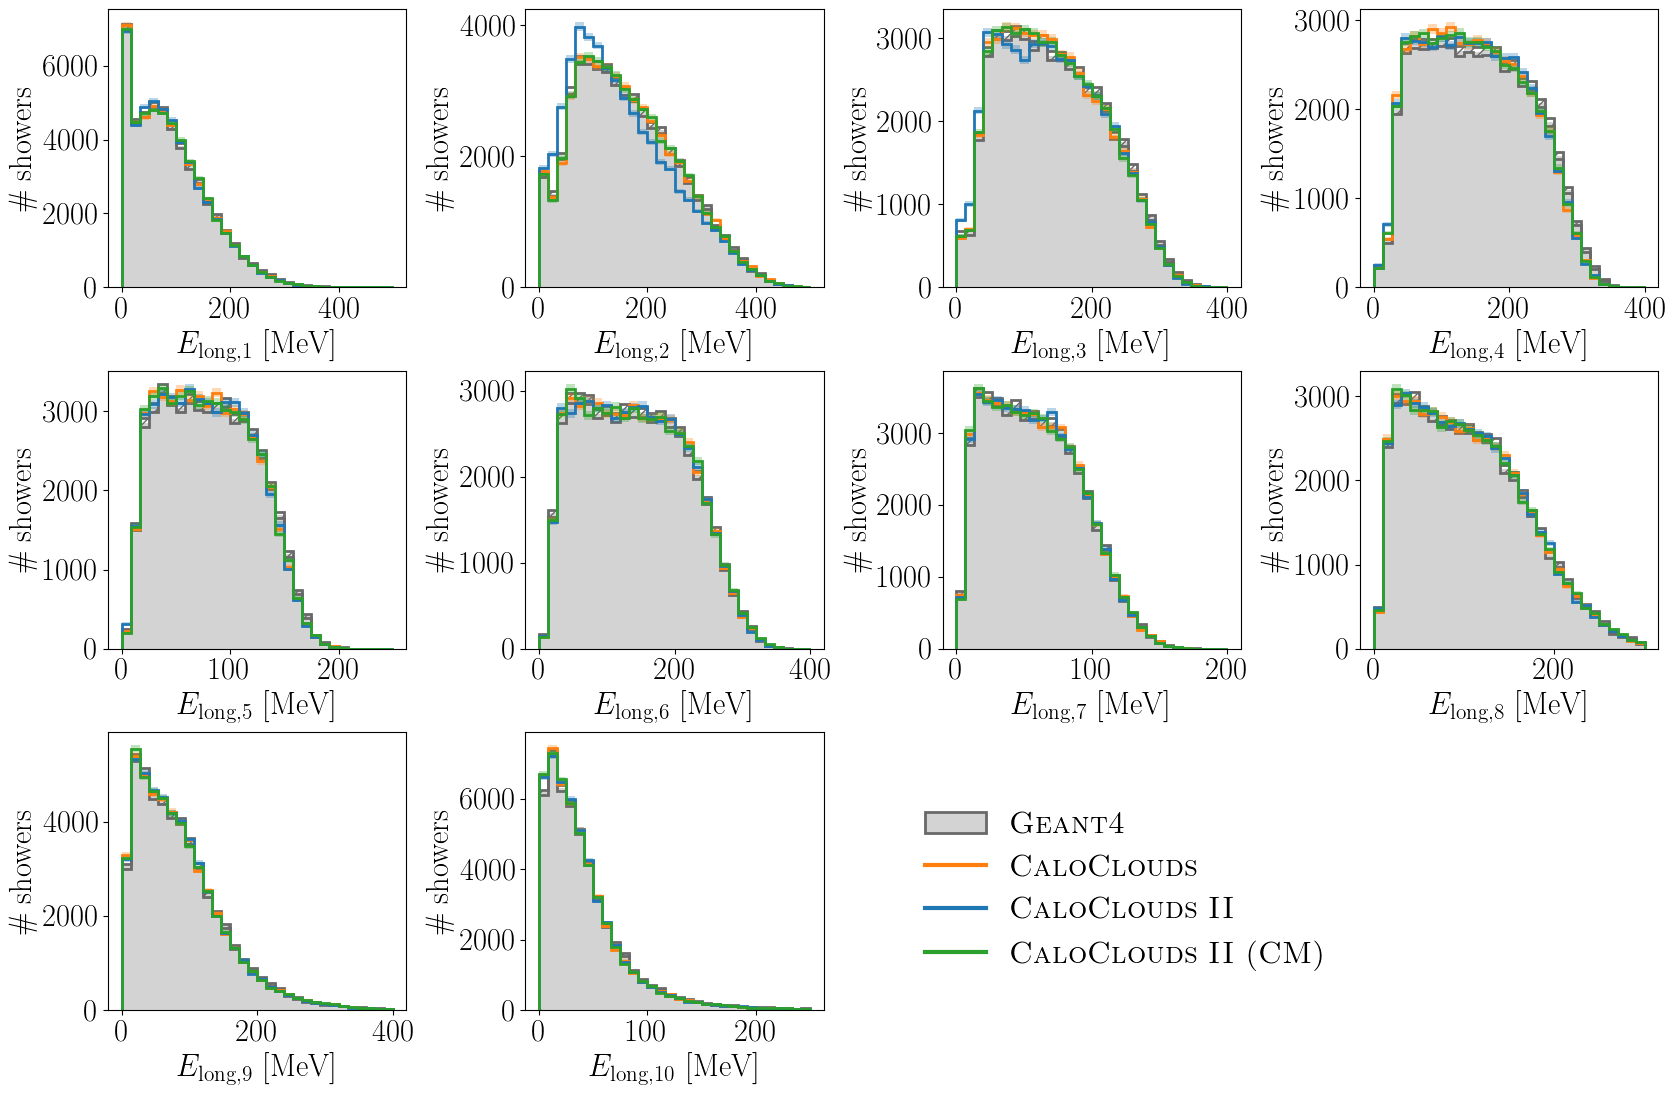

In [9]:
fig = plt.figure(figsize=(20, 13), facecolor='none')
gs = GridSpec(3,4)

j = 0
maxs = [500, 500, 400, 400, 250, 400, 200, 300, 400, 250 ]
for i in range(6,16):
    ax = fig.add_subplot(gs[j])
    min = 0
    max = maxs[j]
    # max = np.max([np.max(obs_real[:,i]), np.max(obs_ddpm[:,i]), np.max(obs_edm[:,i]), np.max(obs_cm[:,i])])
    h = plt.hist(obs_real[:,i], bins=30, range=(min,max), color='lightgrey', rasterized=True)
    # h = plt.hist(obs_real[:,i], bins=30, range=(min,max), color='dimgrey', histtype='step', lw=2)
    h1 = plt.hist(obs_ddpm[:,i], bins=h[1], histtype='step', color=color_lines[0], lw=2)
    h2 = plt.hist(obs_edm[:,i], bins=h[1], histtype='step', color=color_lines[1], lw=2)
    h3 = plt.hist(obs_cm[:,i], bins=h[1], histtype='step', color=color_lines[2], lw=2)

    # unceratinty band
    h_err = np.sqrt(h[0])
    h1_err = np.sqrt(h1[0])
    h2_err = np.sqrt(h2[0])
    h3_err = np.sqrt(h3[0])
    plt.stairs(h[0]+h_err, edges=h[1], baseline=h[0]-h_err, color='dimgrey', lw=2, hatch='///')
    plt.stairs(h1[0]+h1_err, edges=h1[1], baseline=h1[0]-h1_err, color=color_lines[0], fill=True, alpha=0.3)
    plt.stairs(h2[0]+h2_err, edges=h2[1], baseline=h2[0]-h2_err, color=color_lines[1], fill=True, alpha=0.3)
    plt.stairs(h3[0]+h3_err, edges=h3[1], baseline=h3[0]-h3_err, color=color_lines[2], fill=True, alpha=0.3)


    # plt.legend(loc='best')
    plt.xlabel('$E_{{\mathrm{{long}},{0}}}$ [MeV]'.format(j+1))
    plt.ylabel('\# showers')
    # plt.yscale('log')
    j += 1

## for legend ##########################################
plt.hist(np.zeros(1)+1, label=labels[0], color='lightgrey', edgecolor='dimgrey', lw=2)
for i in range(3):
    plt.plot(0, 0, linestyle='-', lw=3, color=color_lines[i], label=labels[i+1])
plt.legend(loc=(1.3, 0.1), fontsize=22)
########################################################

plt.subplots_adjust(wspace=0.4, hspace=0.3)
plt.savefig('plots/energy_layer_bins.pdf', bbox_inches='tight',  dpi=100)
plt.show()

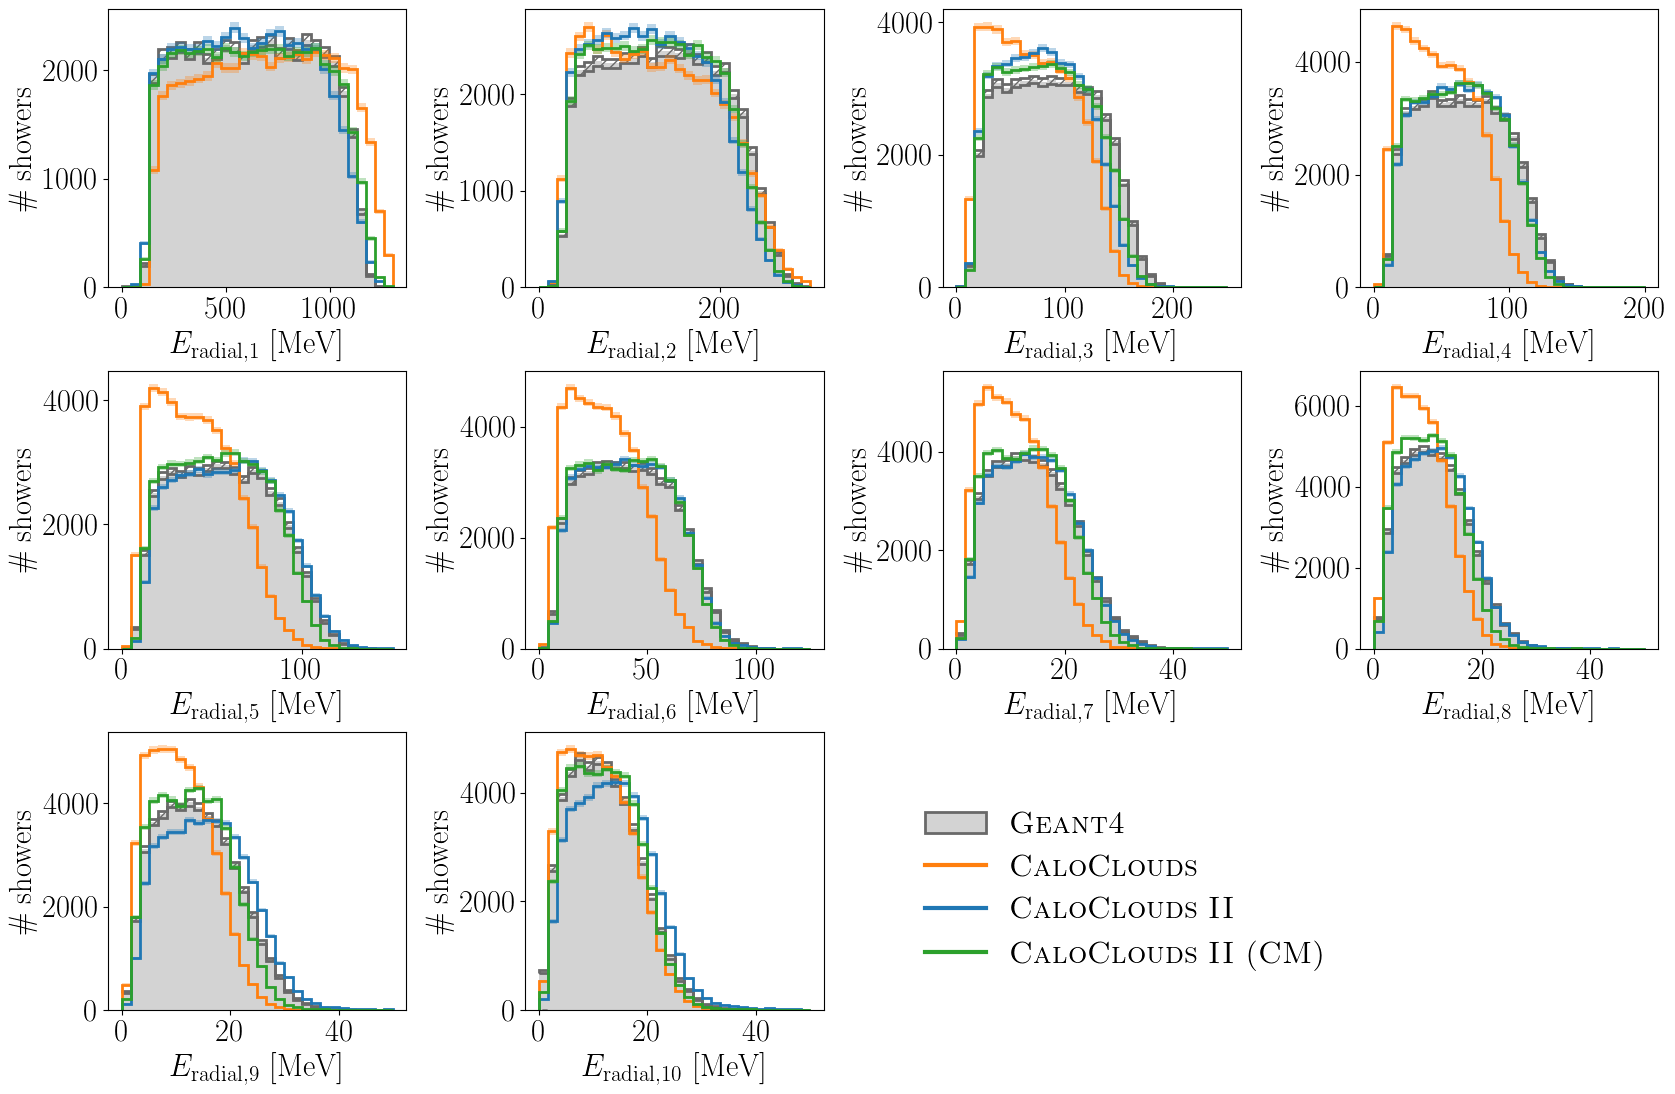

In [12]:
fig = plt.figure(figsize=(20, 13), facecolor='none')
gs = GridSpec(3,4)

j = 0
maxs = [1300, 300, 250, 200, 150, 125, 50, 50, 50, 50 ]
for i in range(16,26):
    ax = fig.add_subplot(gs[j])
    min = 0
    max = maxs[j]
    # max = np.max([np.max(obs_real[:,i]), np.max(obs_ddpm[:,i]), np.max(obs_edm[:,i]), np.max(obs_cm[:,i])])
    h = plt.hist(obs_real[:,i], bins=30, range=(min,max), color='lightgrey', rasterized=True)
    # h = plt.hist(obs_real[:,i], bins=30, range=(min,max), color='dimgrey', histtype='step', lw=2)
    h1 = plt.hist(obs_ddpm[:,i], bins=h[1], histtype='step', color=color_lines[0], lw=2)
    h2 = plt.hist(obs_edm[:,i], bins=h[1], histtype='step', color=color_lines[1], lw=2)
    h3 = plt.hist(obs_cm[:,i], bins=h[1], histtype='step', color=color_lines[2], lw=2)

    # unceratinty band
    h_err = np.sqrt(h[0])
    h1_err = np.sqrt(h1[0])
    h2_err = np.sqrt(h2[0])
    h3_err = np.sqrt(h3[0])
    plt.stairs(h[0]+h_err, edges=h[1], baseline=h[0]-h_err, color='dimgrey', lw=2, hatch='///')
    plt.stairs(h1[0]+h1_err, edges=h1[1], baseline=h1[0]-h1_err, color=color_lines[0], fill=True, alpha=0.3)
    plt.stairs(h2[0]+h2_err, edges=h2[1], baseline=h2[0]-h2_err, color=color_lines[1], fill=True, alpha=0.3)
    plt.stairs(h3[0]+h3_err, edges=h3[1], baseline=h3[0]-h3_err, color=color_lines[2], fill=True, alpha=0.3)

    # plt.legend(loc='best')
    plt.xlabel('$E_{{\mathrm{{radial}},{0}}}$ [MeV]'.format(j+1))
    plt.ylabel('\# showers')
    # plt.yscale('log')
    j += 1

## for legend ##########################################
plt.hist(np.zeros(1)+1, label=labels[0], color='lightgrey', edgecolor='dimgrey', lw=2)
for i in range(3):
    plt.plot(0, 0, linestyle='-', lw=3, color=color_lines[i], label=labels[i+1])
plt.legend(loc=(1.3, 0.1), fontsize=22)
# plt.legend(bbox_to_anchor=(-1.5, -0.3))
########################################################

plt.subplots_adjust(wspace=0.4, hspace=0.3)
plt.savefig('plots/energy_radial_bins.pdf', bbox_inches='tight',  dpi=100)
plt.show()